# Explanatory Data Analysis - (Uber V-TRIP GGU_3)
Masalah/isu: Ketidaksesuaian biaya trip Uber yang ditagihkan ke customer.

Bukti masalah:
1. Relasi abnormal antara durasi trip dan jarak tempuh trip.
2. Waktu tunggu driver yang terlampau lama.
3. Kecepatan rata-rata trip yang terlampau cepat ataupun lambat.

In [1]:
import pandas as pd
import os
from datetime import date, datetime
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance 
import re
import numpy as np
from scipy.stats import skew, boxcox

%matplotlib inline
sns.set()

In [2]:
# OS dependent path
bog_path = os.path.join("dataset", "bog_clean.csv")
mex_path = os.path.join("dataset", "mex_clean.csv")
equ_path = os.path.join("dataset", "uio_clean.csv")

In [3]:
# load bog, mex, and uio csv
bog_df = pd.read_csv(bog_path)
mex_df = pd.read_csv(mex_path)
equ_df = pd.read_csv(equ_path)

In [4]:
bog_df.tail(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
3060,3061,Bogotá,2016-10-27 12:28:22,2016-10-27 01:16:58,-74.061556,4.709213,-74.042396,4.708566,N,2917,10994,1401
3061,3062,Bogotá,2016-10-27 07:40:49,2016-10-27 09:08:09,-74.050934,4.752078,-74.050875,4.752123,N,5240,15803,3076
3062,3063,Bogotá,2016-10-26 04:27:39,2016-10-28 06:50:28,-74.052223,4.705252,-74.050725,4.714622,N,138169,5934,354


In [5]:
mex_df.tail(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
12691,12692,México DF Taxi Libre,2016-10-27 11:19:44,2016-10-27 11:38:35,-99.170637,19.283637,-99.178194,19.280982,N,1131,6051,228
12692,12693,México DF Taxi de Sitio,2016-10-28 06:49:41,2016-10-28 06:51:25,-99.194384,19.396768,-99.194622,19.396717,N,104,49,96
12693,12694,México DF Radio Taxi,2016-10-27 10:26:38,2016-10-28 07:10:21,-99.180135,19.369919,-99.180551,19.372276,N,31424,3448,217


In [6]:
equ_df.tail(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
32363,32364,Quito,2016-10-27 12:10:18,2016-10-27 06:33:53,-78.477247,-0.107514,-78.490093,-0.100859,N,66216,23607,958
32364,32365,Quito,2016-10-25 04:58:55,2016-10-25 05:00:25,-78.550264,-0.256730,-78.550306,-0.256756,N,91,43,70
32365,32366,Quito,2016-10-28 06:47:59,2016-10-28 06:58:31,-78.431986,-0.341538,-78.446296,-0.327428,N,633,3296,150


In [7]:
print(bog_df.shape)
print(mex_df.shape)
print(equ_df.shape)

(3063, 12)
(12694, 12)
(32366, 12)


In [8]:
# check missing data each files
bog_df.isna().sum(axis=0)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64

In [9]:
mex_df.isna().sum(axis=0)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64

In [10]:
equ_df.isna().sum(axis=0)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64

no NaN value for each file

In [11]:
# add a feature that contain the country name to distinguish 'em later
bog_df["country"] = "colombia"
mex_df["country"] = "mexico"
equ_df["country"] = "equador"

check longitude and latitude with marker for each country.

check map_checker.ipynb how to generate the picture and yes i've been thru that hell of lagging

(its faster and lighter to load an image than folium with tons of marker)

Bogota map plot : 


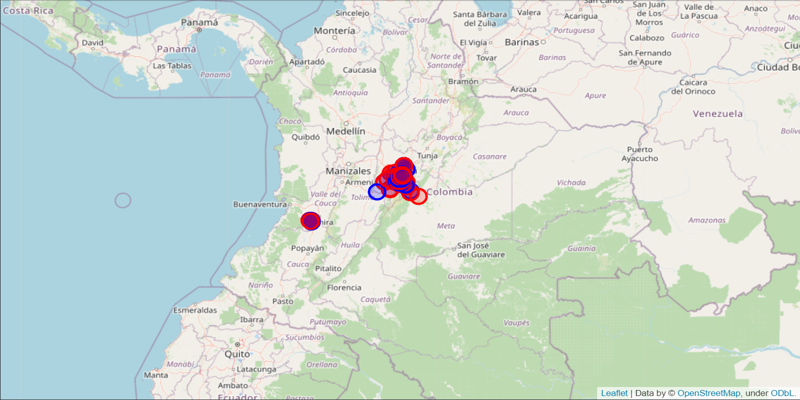

In [12]:
# plot map with marker each country 
IMG_WIDTH = 800
IMG_HEIGHT = 400

img = Image.open(os.path.join("assets", "bog_plot.png"))
img = img.resize((IMG_WIDTH, IMG_HEIGHT))
print("Bogota map plot : ")
img

Mexico map plot : 


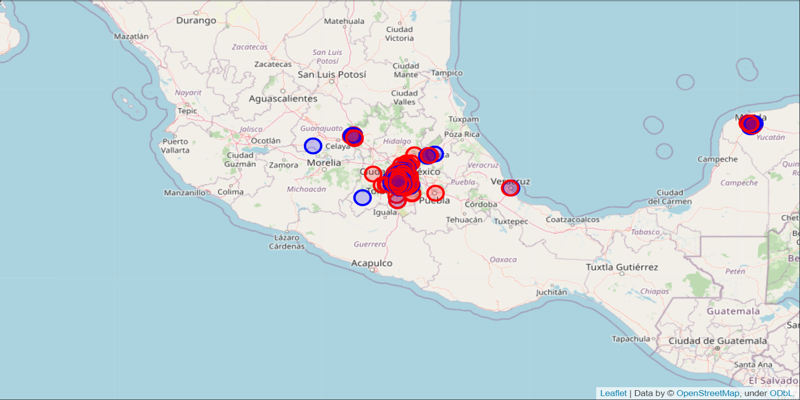

In [13]:
img = Image.open(os.path.join("assets", "mex_plot.png"))
img = img.resize((IMG_WIDTH, IMG_HEIGHT))
print("Mexico map plot : ")
img

Equador map plot : 


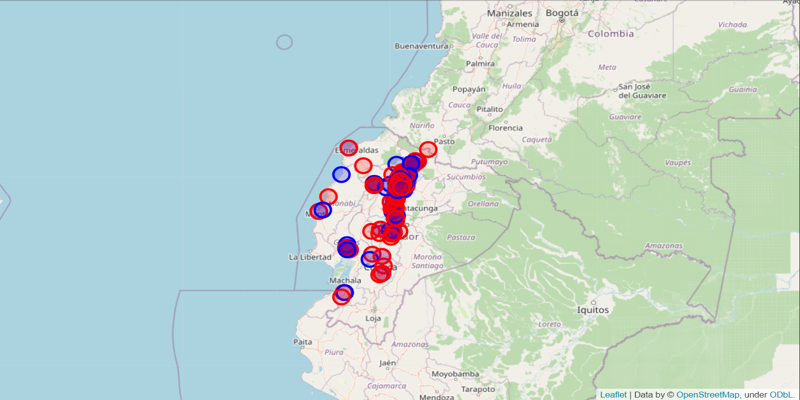

In [14]:
img = Image.open(os.path.join("assets", "equ_plot.png"))
img = img.resize((IMG_WIDTH, IMG_HEIGHT))
print("Equador map plot : ")
img

looks good no missing data, also the lat long is within the country, lets just concat the datasets from bogota, mexico, and equador

In [15]:
# concat csv
dataset_df = pd.concat([bog_df, mex_df, equ_df], ignore_index=True)
print(dataset_df.shape)

(48123, 13)


In [16]:
# check type data each column
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48123 entries, 0 to 48122
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  48123 non-null  int64  
 1   vendor_id           48123 non-null  object 
 2   pickup_datetime     48123 non-null  object 
 3   dropoff_datetime    48123 non-null  object 
 4   pickup_longitude    48123 non-null  float64
 5   pickup_latitude     48123 non-null  float64
 6   dropoff_longitude   48123 non-null  float64
 7   dropoff_latitude    48123 non-null  float64
 8   store_and_fwd_flag  48123 non-null  object 
 9   trip_duration       48123 non-null  int64  
 10  dist_meters         48123 non-null  int64  
 11  wait_sec            48123 non-null  int64  
 12  country             48123 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 4.8+ MB


Berdasarkan informasi di atas, dataset kita tidak terdapat nilai Null. Selain itu, semua tipe data fitur sesuai dengan peruntukkannya. Maka, tidak perlu dilakukan pengisian nilai Null dan konversi tipe data.

In [17]:
# check categorical features data
for i in dataset_df[["vendor_id", "store_and_fwd_flag", "country"]] :
    print(f"{i} : {dataset_df[i].unique()} \n")

vendor_id : ['Bogotá' 'Bogotá UberX' 'Bogota UberBlack' 'Bogotá UberVan'
 'Bogotá UberAngel' 'México DF Taxi de Sitio' 'México DF Taxi Libre'
 'México DF Radio Taxi' 'México DF UberX' 'México DF UberXL'
 'México DF UberSUV' 'México DF UberBlack' 'Quito' 'Quito Cabify Lite'
 'Quito Cabify Executive' 'Quito UberX'] 

store_and_fwd_flag : ['N'] 

country : ['colombia' 'mexico' 'equador'] 



so store_and_fwd_flag only have one unique value, just drop it coz not very useful, also drop id

In [18]:
# drop store_and_fwd_flag and id
dataset_df = dataset_df.drop(["store_and_fwd_flag", "id"], axis=1)

In [19]:
# check and drop if there is any duplicated data
dataset_df = dataset_df.drop_duplicates()
print(dataset_df.shape)
print("drop duplicated data : {}".format(48123-47388))

(47388, 11)
drop duplicated data : 735


In [20]:
# change date and time format
dataset_df["pickup_datetime"] = pd.to_datetime(dataset_df["pickup_datetime"], format="%Y/%m/%d %H:%M:%S")
dataset_df["dropoff_datetime"] = pd.to_datetime(dataset_df["dropoff_datetime"], format="%Y/%m/%d %H:%M:%S")

In [21]:
# check max and minimum time
print("pickup & dropoff maximal time is {} {}".format(
    dataset_df["pickup_datetime"].dt.time.max(), 
    dataset_df["dropoff_datetime"].dt.time.max())
)

print("pickup & dropoff minimum time is {} {}".format(
    dataset_df["pickup_datetime"].dt.time.min(), 
    dataset_df["dropoff_datetime"].dt.time.min())
)

pickup & dropoff maximal time is 12:59:59 12:59:59
pickup & dropoff minimum time is 01:00:01 01:00:01


there is no AM PM notation but the time is maxed at 12:59:59 and there is no 00:00:00 time range.

strip the time, because not useful and might lead to mis-calculation

In [22]:
# strip time from datetime
dataset_df["pickup_datetime"] = pd.to_datetime(dataset_df["pickup_datetime"]).dt.date
dataset_df["dropoff_datetime"] = pd.to_datetime(dataset_df["dropoff_datetime"]).dt.date

In [23]:
# sort by pickup date time
dataset_df = dataset_df.sort_values(by=["pickup_datetime"])
dataset_df = dataset_df.reset_index(drop=True)

In [24]:
dataset_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,47388.000000,47388.000000,47388.000000,47388.000000,4.738800e+04,4.738800e+04,4.738800e+04
mean,-83.701066,5.321787,-83.700891,5.320583,3.854506e+04,-3.860076e+04,1.541136e+07
std,9.350035,8.542780,9.348693,8.544595,5.106782e+05,1.708677e+07,6.051557e+08
min,-108.985069,-3.454279,-108.987429,-3.574739,-3.887110e+05,-2.147484e+09,0.000000e+00
25%,-99.059911,-0.198614,-99.043489,-0.202007,4.960000e+02,2.021000e+03,1.010000e+02
50%,-78.499611,-0.149571,-78.498360,-0.150728,9.435000e+02,4.120500e+03,2.430000e+02
75%,-78.477705,19.283737,-78.479058,19.283099,1.951250e+03,7.855250e+03,5.340000e+02
max,-73.829723,25.752964,-73.615700,25.781058,7.002605e+07,2.147484e+09,9.516306e+10


Sebagai awalan, bahkan dari summary statistiknya saja dapat kita lihat terdapat kesalahan dalam recording data oleh apps. Sebagai contoh, fitur durasi trip (trip_duration) dan jarak tempuh trip (dist_meters) mempunyai nilai maksimum dan minimun yang terlampau jauh, bahkan bisa dikatakan sebagai data outlier/pencilan.

##### Bukti masalah 1: Relasi abnormal antara durasi trip dan jarak tempuh trip.

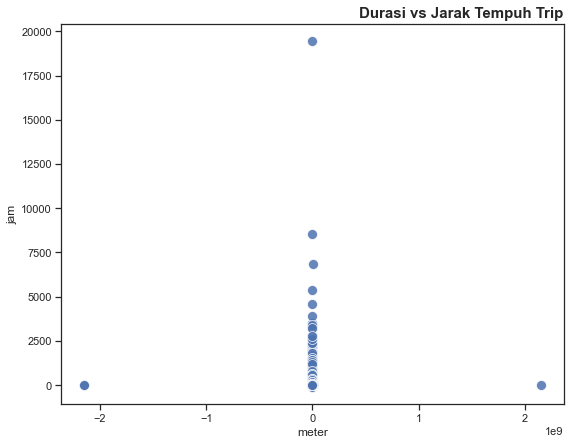

In [25]:
# plot dist_meter and trip_duratuion in hour
plt.figure(figsize=(9, 7))
with sns.axes_style(style="ticks"):
    sns.scatterplot(
        data=dataset_df,
        x="dist_meters",
        y=dataset_df.trip_duration/3600,
        s=100,
        alpha=0.85
    )
plt.title("Durasi vs Jarak Tempuh Trip",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("meter")
plt.ylabel("jam");

Grafik "Durasi vs Jarak Tempuh Trip" mendukung pernyataan di bagian summary statistik. Dapat dilihat bahwa terdapat beberapa data yang terletak sangat jauh dari sebaran data mayoritas/yang benar (tengah). Data yang sangat jauh tersebut merupakan data yang salah di-record oleh apps, sehingga merupakan trip yang False.

##### Bukti masalah 2: Waktu tunggu driver yang terlampau lama.

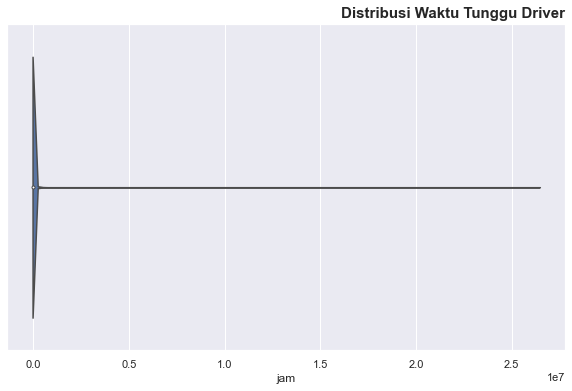

In [26]:
# plot wait_sec distribution
plt.figure(figsize=(10, 6))

with sns.axes_style(style="darkgrid"):
    sns.violinplot(x=dataset_df["wait_sec"]/3600)

plt.title(
    "Distribusi Waktu Tunggu Driver",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("jam");

Berdasarkan grafik "Distribusi Waktu Tunggu Driver" dapat dilihat terdapat beberapa data yang bernilai sangat besar (jutaan jam). Hal ini sangat tidak masuk akal dan tentunya dapat dipastikan bahwa nilai yang sangat besar tersebut merupakan data yang salah di-record oleh apps, sehingga merupakan trip yang False.

##### Bukti masalah 3: Kecepatan rata-rata trip yang terlampau cepat ataupun lambat.

In [27]:
# calculate speed in km/h
speed_kmph = (dataset_df["dist_meters"] / 1000) / (dataset_df["trip_duration"] / 3600)
speed_kmph.describe()

count    4.738800e+04
mean    -2.597491e+02
std      7.650799e+04
min     -1.498244e+07
25%      9.356612e+00
50%      1.638941e+01
75%      2.269694e+01
max      5.942307e+06
dtype: float64

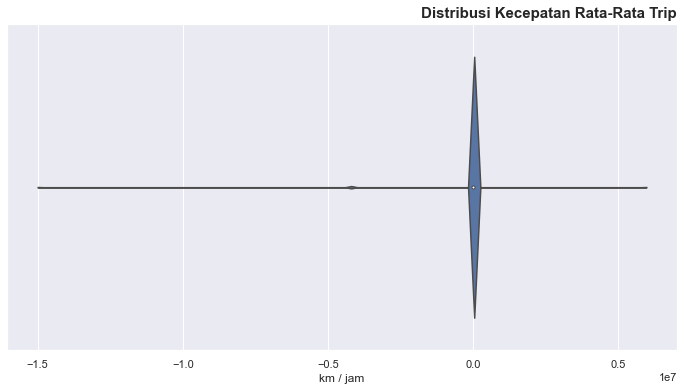

In [28]:
# plot kmph distribution
plt.figure(figsize=(12, 6))
with sns.axes_style(style="darkgrid"):
    sns.violinplot(x=speed_kmph)

plt.title(
    "Distribusi Kecepatan Rata-Rata Trip",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("km / jam");

Berdasarkan summary statistik fitur **speed_kmph** dan grafik "Distribusi Kecepatan Rata-Rata Trip" dapat dilihat bahwa terdapat beberapa data dengan nilai kecepatan rata-rata trip yang sangat besar (5.9 juta km/jam) dan bahkan negatif (-14 juta km/jam).  Hal ini lagi-lagi sangat tidak masuk akal dan tentunya dapat dipastikan bahwa nilai yang sangat besar dan negatif tersebut merupakan data yang salah di-record oleh apps, sehingga merupakan trip yang False.

### Feature Engineering

In [29]:
# Copy dataset for play-ground code
df_cp = dataset_df

In [30]:
# bunch of custom functions

def geodesic(p_lon, p_lat, d_lon, d_lat) :
    # calculate distance using geodesic method
    # COEF is a coeficient for calibrating the geodesic result to nearly match osrm
    # see trip_estimator_methods.ipynb for coeficient
    # distance in meters
    COEF = 1.5165
    pickup = (p_lat, p_lon)
    dropoff = (d_lat, d_lon)
    result = distance(pickup, dropoff).km
    return result * COEF * 1000

def distance_estimator(df) :
    # calculate the duration then append to est_duration
    # using geodesic
    # name the estimated distance to est_meters
    distance = []
    for i in range(len(df)) :
        PICKUP_LONG = df.pickup_longitude[i]
        PICKUP_LAT = df.pickup_latitude[i]
        DROPOFF_LONG = df.dropoff_longitude[i]
        DROPOFF_LAT = df.dropoff_latitude[i]
        result = geodesic(PICKUP_LONG, PICKUP_LAT, DROPOFF_LONG, DROPOFF_LAT)
        distance.append(int(result))
    return distance

def duration_estimator(df) :
    # dalam kota limit 50 km/h
    # pemukiman limit 30 km/h
    # ambil rata-rata kecepatan jadi 40 km/h
    # and please name the estimated distance to est_meters or this doesnt work
    # also note : 40 km/h to 60 km/h have 0.6667 scale difference
    # 40km/h to 15 km/h have 2.6667 scale difference
    # use that for time tolerance
    time = []
    for i in range(len(df)) :
        d = df.est_meters[i]
        v = 40 # average speed in km/h
        t = d / (v * (1000/3600)) # time travel in seconds
        time.append(int(t))
    return time

def labeler(df) :
    # make label 0 : False or 1 : True, based on below :
    # if the day taken is > 1, false
    # if the distance lower or higher than est_distance  + tolerance, false
    # if the duration lower or higher than est_duration + tolerance, false
    # set the distance tolerance to + 20% for taking shortcut and 50% taking longer route
    # set the duration tolerance to + 50% like very congested road
    # set the trip duration tolerance to (lower bound : * 0.6667) and (higher bound : * 2.6667)
    # distance < 800 meters, false
    # wait_sec > 5 minutes, false
    # trip_duration < 3 minutes, false (because 3 minutes with 20km/h is 1000 meters)
    # why ? because this is car service
    # so basicly comparing the real distance and duration if its inside the lower and higher est bounds
    DISTB = 800
    TRIPB = 3 * 60
    WT = 5 * 60
    label = []
    for i in range(len(df)) :
        day_delta = (df.dropoff_datetime[i] - df.pickup_datetime[i]).days
        DLB = df.est_meters[i] * 0.8 # mean might be closer
        DHB = df.est_meters[i] * 1.5 # mean might be further
        TLB = df.est_duration[i] * 0.6667 # mean might be faster (~ 40km/h - 60km/h)
        THB = df.est_duration[i] * 2.6667 * 1.5 # mean might be slower (~ 15km/h - 40km/h) and 50% longer
        if day_delta > 1 :
            label.append(0)
        elif df.est_meters[i] < DISTB : 
            label.append(0)
        elif df.trip_duration[i] < TRIPB :
            label.append(0)
        elif df.wait_sec[i] > WT : 
            label.append(0)
        elif (df.dist_meters[i] > DLB) and (df.dist_meters[i] < DHB) :
            if (df.trip_duration[i] > TLB) and (df.trip_duration[i] < THB) :
                label.append(1)
            else :
                label.append(0)
        else :
            label.append(0)
    return label

def services_extractor(df) :
    # extract services name from vendor_id and map the services based in 2022
    # some normal services is not available in 2022, it'll be taxi service instead
    # uberangel is exclusive to colombia, it'll be uberblack service instead
    # ubersuv will be uberxl
    SERVICE_NAME = re.compile(
        r"taxi|uberxl|uberx|uberblack|ubervan|uberangel|ubersuv"
    )
    df["vendor_id"] = df["vendor_id"].str.lower()
    service = []
    for i in range(len(df)) :
        extract = SERVICE_NAME.search(df.vendor_id[i])
        if extract != None :
            ext_group = extract.group()
            if (ext_group  == "ubervan") or (ext_group == "ubersuv"):
                service.append("uberxl")
            elif ext_group == "uberangel" :
                service.append("uberblack")
            else : 
                service.append(ext_group)
        else :
            service.append("taxi")
    return service

def price_estimator(df) :
    # estimate the price based on 2022 uber price
    # the price is in US dollar
    # base fare + rate per menit + rate per KM
    # if the calculated price is lower than minimum fare, use minimum fare
    # cancel fee charged if trip duration below 1 minutes
    price_path = os.path.join("dataset", "uber_prices_2022.csv")
    price_df = pd.read_csv(price_path)
    TRIPB = 3 * 60
    CB =  60
    WT = 5 * 60
    total = []
    for i in range(len(df_cp)) :
        service = df_cp.service[i]
        country = df_cp.country[i]
        label = df_cp.label[i]
        p_service_data = price_df[(price_df.country == f"{country}") & (price_df.name == f"{service}")]
        MIN_FARE = round(float(p_service_data["min_fare"]), 1)
        BASE_FARE = float(p_service_data["base_fare"])
        CANCEL_FEE = round(float(p_service_data["cancel_fee"]), 1)
        if label == 1 :
            # VALID DATA CALCULATION
            # True data already wait_sec < 7 minutes
            if df.trip_duration[i] >= CB : 
                # for valid NOT cancel
                PER_MIN = float(p_service_data["per_min"]) * df.trip_duration[i] / 60
                PER_KM = float(p_service_data["per_km"]) * df.dist_meters[i] / 1000
                calc = BASE_FARE + PER_MIN + PER_KM
                calc = round(calc, 1)
                if calc >= MIN_FARE :
                    total.append(calc)
                else :
                    total.append(MIN_FARE)
            else : 
                # for valid but cancel
                calc = CANCEL_FEE
                total.append(calc)
        else :
            # NOT VALID DATA CALCULATION BUT LEGIT wait_sec
            # theres must be data with 0 label but wait_sec is valid
            if (df.est_duration[i] >= CB + TRIPB) and (df.wait_sec[i] < WT) :
                # for NOT valid but NOT cancel
                PER_MIN = float(p_service_data["per_min"]) * df.est_duration[i] / 60
                PER_KM = float(p_service_data["per_km"]) * df.est_meters[i] / 1000
                calc = BASE_FARE + PER_MIN + PER_KM
                calc = round(calc, 1)
                if calc >= MIN_FARE :
                    total.append(calc)
                else :
                    total.append(MIN_FARE)
            else :
                # for NOT valid but cancel
                # also 0 label data but waiting more than 7 minutes
                calc = CANCEL_FEE
                total.append(calc)
    return total

In [31]:
# make a new engineered feature
df_cp["service"] = services_extractor(df_cp)
df_cp["est_meters"] = distance_estimator(df_cp)
df_cp["est_duration"] = duration_estimator(df_cp)
df_cp["label"] = labeler(df_cp)

In [32]:
# make sure if the services mapped correctly
df_cp["service"].unique()

array(['taxi', 'uberx', 'uberxl', 'uberblack'], dtype=object)

In [33]:
df_cp["price"] = price_estimator(df_cp)

In [34]:
# check new engineered features + wait_sec samples
df_cp[["service", "country", "dist_meters", "est_meters", "trip_duration", "est_duration", "wait_sec", "label", "price"]].sample(5)

,service,country,dist_meters,est_meters,trip_duration,est_duration,wait_sec,label,price
42729,taxi,mexico,888,1185,1028,106,38,0,0.0
40650,taxi,equador,18449,27488,8460,2473,34,0,15.8
35388,taxi,equador,2431,2236,593,201,868571874,0,0.0
8588,taxi,equador,2692,3114,1338,280,841,0,0.0
35206,taxi,equador,95,139,18,12,6,0,0.0


In [35]:
print(list(df_cp["label"].values).count(1))
print(list(df_cp["label"].values).count(0))

12194
35194


pretty unbalanced but lets analyze the True data

In [36]:
# load only True data
true_data = df_cp[(df_cp.label == 1)]

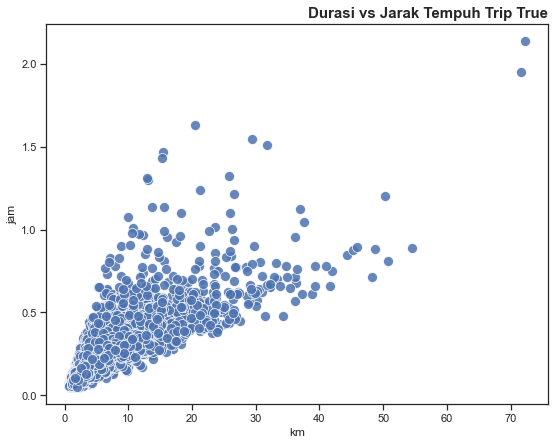

In [37]:
# plot dist_meter and trip_duratuion in hour
plt.figure(figsize=(9, 7))
with sns.axes_style(style="ticks"):
    sns.scatterplot(
        data=true_data,
        x=true_data.dist_meters / 1000,
        y=true_data.trip_duration / 3600,
        s=100,
        alpha=0.85
    )
plt.title("Durasi vs Jarak Tempuh Trip True",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("km")
plt.ylabel("jam");

In [38]:
speed_kmph = (true_data["dist_meters"] / 1000) / (true_data["trip_duration"] / 3600)
speed_kmph.describe()

count    12194.000000
mean        23.199942
std          8.201688
min          8.077490
25%         17.396402
50%         21.663202
75%         27.351208
max         72.048336
dtype: float64

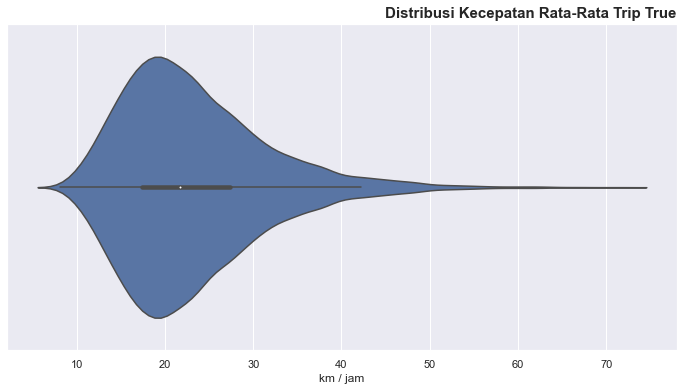

In [39]:
# plot kmph distribution
plt.figure(figsize=(12, 6))
with sns.axes_style(style="darkgrid"):
    sns.violinplot(x=speed_kmph)

plt.title(
    "Distribusi Kecepatan Rata-Rata Trip True",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("km / jam");

better than before, the speed maxed at 72.048336... not intergalactic spaceship anymore or even a negative speed

In [40]:
(true_data["wait_sec"] / 60).describe()

count    12194.000000
mean         2.471385
std          1.298766
min          0.000000
25%          1.383333
50%          2.400000
75%          3.516667
max          5.000000
Name: wait_sec, dtype: float64

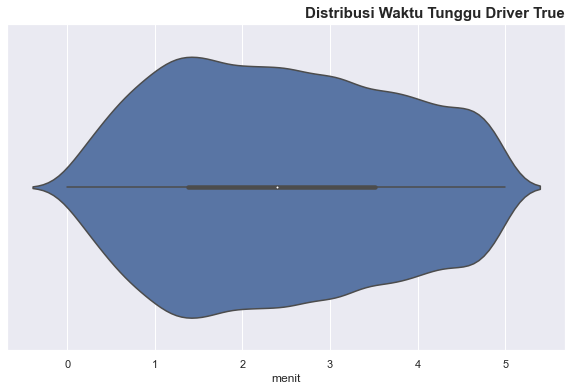

In [41]:
# plot wait_sec distribution
plt.figure(figsize=(10, 6))

with sns.axes_style(style="darkgrid"):
    sns.violinplot(x=true_data["wait_sec"] / 60)

plt.title(
    "Distribusi Waktu Tunggu Driver True",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("menit");

much better waiting time for driver, the true data doesnt contain driver data waiting a rider for eternity to pickup

In [42]:
true_data["price"].describe()

count    12194.000000
mean         3.505700
std          2.380507
min          1.100000
25%          2.100000
50%          2.900000
75%          4.100000
max         48.800000
Name: price, dtype: float64

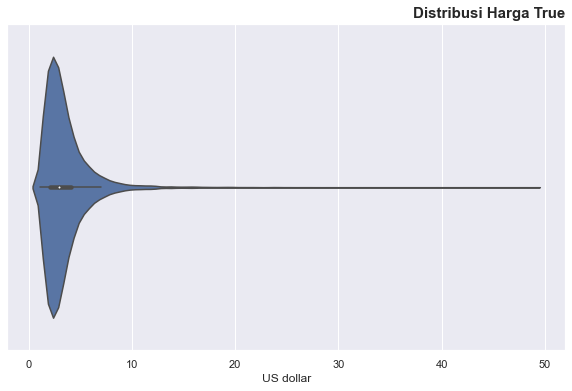

In [43]:
# plot price distribution
plt.figure(figsize=(10, 6))

with sns.axes_style(style="darkgrid"):
    sns.violinplot(x=true_data["price"])

plt.title(
    "Distribusi Harga True",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("US dollar");

In [44]:
# load only False data
false_data = df_cp[(df_cp.label == 0)]

In [45]:
# check false data
false_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,est_meters,est_duration,label,price
count,35194.000000,35194.000000,35194.000000,35194.000000,3.519400e+04,3.519400e+04,3.519400e+04,35194.000000,35194.000000,35194.0,35194.000000
mean,-83.729493,5.433236,-83.729528,5.431581,5.165654e+04,-5.363415e+04,2.075102e+07,5536.532676,497.789169,0.0,0.748488
std,9.418935,8.559407,9.417698,8.561524,5.920184e+05,1.982718e+07,7.021336e+08,10921.599559,982.942665,0.0,3.403650
min,-108.985069,-3.454279,-108.987429,-3.574739,-3.887110e+05,-2.147484e+09,0.000000e+00,0.000000,0.000000,0.0,0.000000
25%,-99.060346,-0.196812,-99.051087,-0.199725,5.930000e+02,1.808000e+03,1.180000e+02,887.250000,79.000000,0.0,0.000000
50%,-78.498659,-0.145306,-78.497942,-0.147987,1.236000e+03,4.473500e+03,3.560000e+02,3289.000000,296.000000,0.0,0.000000
75%,-78.477458,19.293667,-78.478840,19.289503,2.674750e+03,8.771000e+03,7.050000e+02,7322.000000,658.000000,0.0,0.000000
max,-73.829723,25.752964,-73.615700,25.781058,7.002605e+07,2.147484e+09,9.516306e+10,605326.000000,54479.000000,0.0,231.000000


The data is good for enough for T / F classification, lets see useful feature !

<AxesSubplot:>

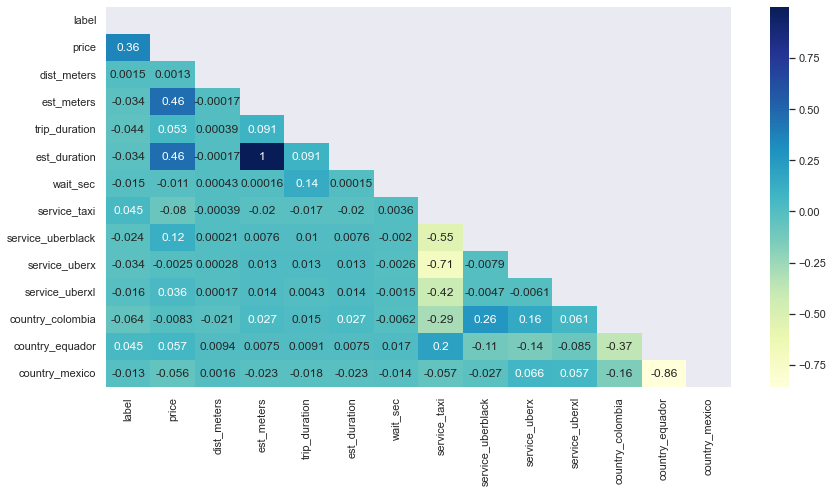

In [46]:
cm_label = df_cp[["label", "price", "service", "country", "dist_meters", "est_meters", "trip_duration", "est_duration", "wait_sec"]]
cm_label = pd.get_dummies(cm_label)
plt.figure(figsize=(14,7))
sns.heatmap(cm_label.corr(), annot=True, cmap="YlGnBu", mask=np.triu(cm_label.corr()))

maybe gonna pick them all except dist_meters, yolo

In [47]:
# export classification model csv
export_csv = cm_label.drop(["dist_meters"], axis = 1)
export_csv.to_csv(os.path.join("dataset", "GGU_classification.csv"))

# False data keeping for price estimator

In [48]:
# check problematic data
false_data[(false_data.trip_duration < 0) | (false_data.dist_meters < 0)]

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,country,service,est_meters,est_duration,label,price
17806,quito,2016-12-12,2016-12-08,-78.437117,-0.216644,-78.438909,-0.215610,-388711,242,388780,equador,taxi,348,31,0,0.0
34857,bogotá,2017-05-05,2017-05-05,-74.113738,4.614926,-74.120487,4.622169,516,-2147483648,313,colombia,taxi,1662,149,0,0.0
34858,bogotá,2017-05-05,2017-05-05,-74.119734,4.621434,-74.088679,4.680280,1843,-2147483648,1240,colombia,taxi,11166,1004,0,0.0


In [49]:
pf_data = false_data[(false_data.trip_duration >= 0) & (false_data.dist_meters >= 0)]
pf_data = pf_data[((pf_data.est_meters / 1000) / (pf_data.est_duration / 3600)) <= true_data["dist_meters"].max()]

In [50]:
print(true_data["dist_meters"].max())
print(pf_data["est_meters"].max())

72325
605326


In [51]:
# sort logic distance by True label max distance
pf_data = pf_data[(pf_data.est_meters <= true_data["dist_meters"].max())]

In [52]:
pf_data["price"].describe()

count    34630.000000
mean         0.710811
std          2.130125
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         46.100000
Name: price, dtype: float64

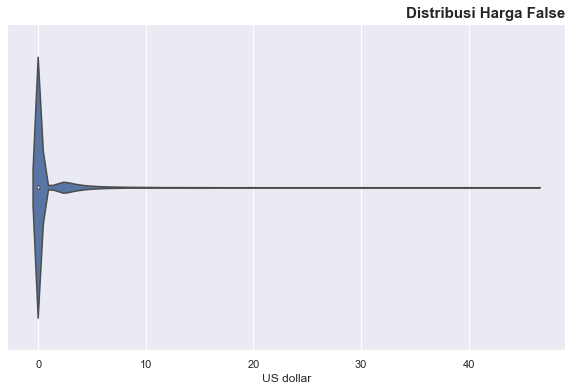

In [53]:
# plot price distribution
plt.figure(figsize=(10, 6))

with sns.axes_style(style="darkgrid"):
    sns.violinplot(x=pf_data["price"])

plt.title(
    "Distribusi Harga False",
    loc="right",
    fontweight="bold",
    size=15
)
plt.xlabel("US dollar");

In [54]:
price_est_df = pd.concat([true_data, pf_data], ignore_index=True)
price_est_df = price_est_df.sort_values(by=["pickup_datetime"])
price_est_df = price_est_df.reset_index(drop=True)

Lets analyze the data for price predict

<AxesSubplot:xlabel='price'>

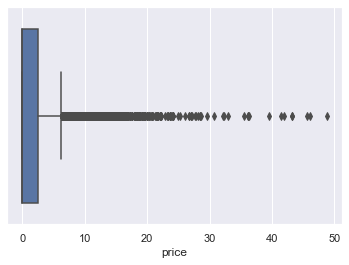

In [55]:
sns.boxplot(
    data=price_est_df,
    x= "price"
)

In [56]:
MAX_TRESHOLD = price_est_df['price'].quantile(0.99)
MAX_TRESHOLD

10.8

In [57]:
# removing outliers
price_est_df = price_est_df[(price_est_df.price < MAX_TRESHOLD)]

<AxesSubplot:>

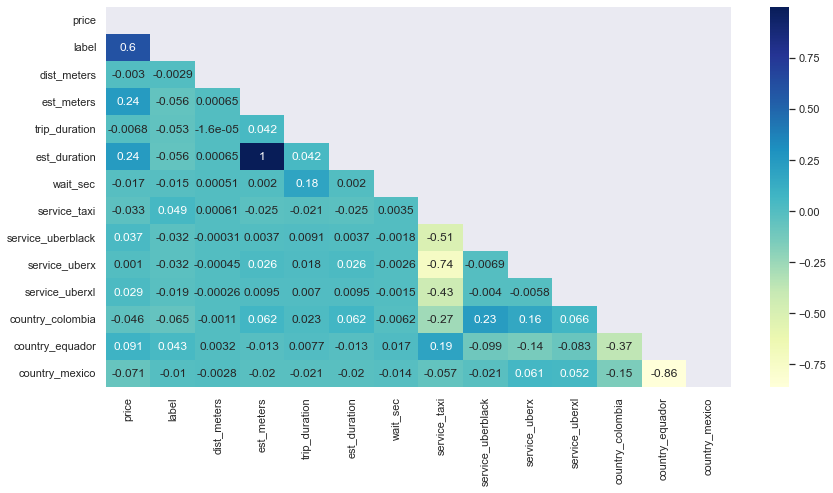

In [58]:
cm_price = price_est_df[["price", "label", "service", "country", "dist_meters", "est_meters", "trip_duration", "est_duration", "wait_sec"]]
cm_price = pd.get_dummies(cm_price)
plt.figure(figsize=(14,7))
sns.heatmap(cm_price.corr(), annot=True, cmap="YlGnBu", mask=np.triu(cm_price.corr()))

label, est_meters, est_duration is somewhat good corelated

In [59]:
price_df = cm_price[["label", "est_meters", "est_duration"]]

2.491482142966139


<Figure size 432x288 with 0 Axes>

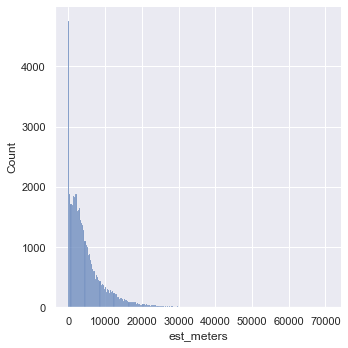

In [60]:
print(skew(price_df["est_meters"]))
plt.figure()
sns.displot(price_df["est_meters"])

In [61]:
price_df["est_meters"] = boxcox(price_df["est_meters"])[0]
print(skew(price_df["est_meters"]))

-0.057630279550071106


C:\Users\enricoroselino\AppData\Local\Temp\ipykernel_31388\2207869817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df["est_meters"] = boxcox(price_df["est_meters"])[0]


2.4914781979082803


<Figure size 432x288 with 0 Axes>

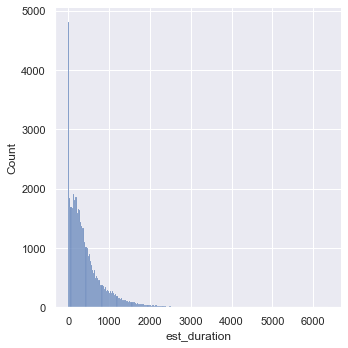

In [62]:
print(skew(price_df["est_duration"]))
plt.figure()
sns.displot(price_df["est_duration"])

In [63]:
price_df["est_duration"] = boxcox(price_df["est_duration"])[0]
print(skew(price_df["est_duration"]))

-0.05959623540863608


C:\Users\enricoroselino\AppData\Local\Temp\ipykernel_31388\9026872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df["est_duration"] = boxcox(price_df["est_duration"])[0]


In [64]:
# export price predict  model csv
export_csv = price_df
export_csv.to_csv(os.path.join("dataset", "GGU_price_predict.csv"))

In [67]:
!jupyter-nbconvert --to PDFviaHTML EDA.ipynb

[NbConvertApp] Converting notebook EDA.ipynb to PDFviaHTML
[NbConvertApp] Writing 2944962 bytes to EDA.pdf
